In [1]:
import pandas as pd
import numpy as np

hotels_df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-11/hotels.csv')

In [2]:
hotels_df.drop(axis = 1, columns = ['arrival_date_day_of_month', 'arrival_date_week_number',
                                    'arrival_date_year','reservation_status','reservation_status_date', 
                                    'company'], inplace = True)

<Figure size 432x288 with 0 Axes>

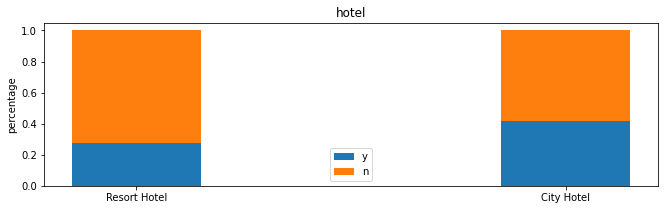

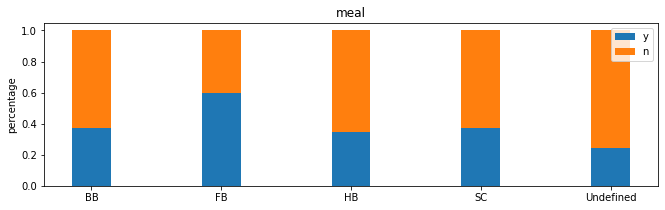

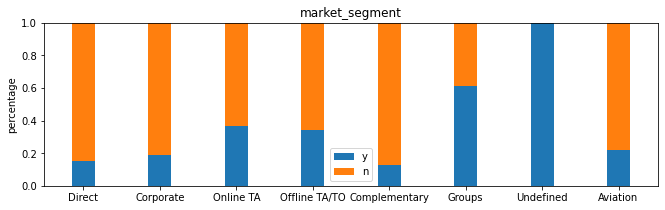

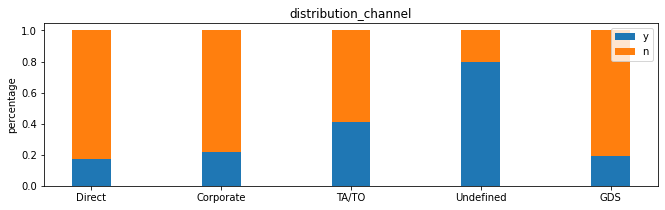

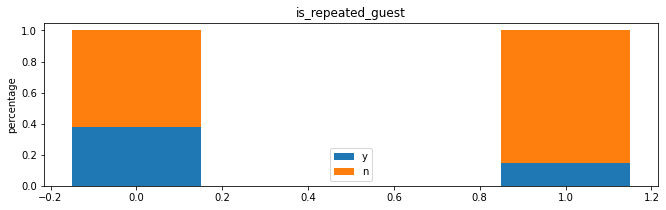

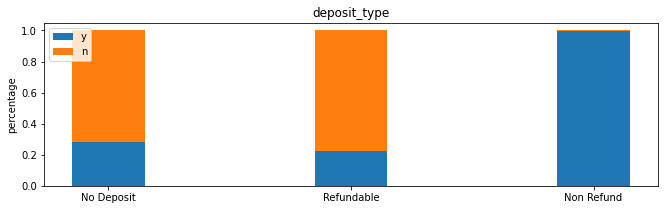

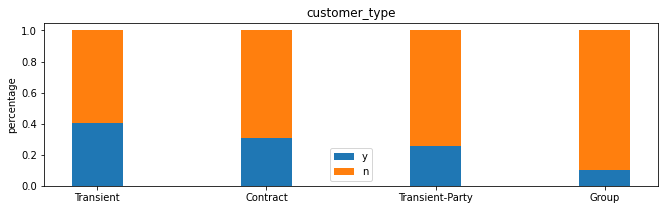

In [3]:
import matplotlib.pyplot as plt

i = 1
for col in hotels_df.columns:
    if (hotels_df[col].dtype == 'object' or col == 'is_repeated_guest') and hotels_df[col].nunique() < 10:
        categories = hotels_df[col].unique()
        y = []
        n = []
        for instance in categories:
            y_p = sum(hotels_df['is_canceled'].loc[hotels_df[col] == instance])
            y_p = y_p/len(hotels_df['is_canceled'].loc[hotels_df[col] == instance])
            n_p = 1 - y_p
            y.append(y_p)
            n.append(n_p)
        plt.figure(i)
        plt.figure(figsize = (11, 3)) 
        plt.bar(categories, y, 0.3, label = 'y')
        plt.bar(categories, n, 0.3, bottom = y, label = 'n')
        plt.title(col)
        plt.ylabel("percentage")
        plt.legend()
        i = i + 1
plt.show()

<Figure size 432x288 with 0 Axes>

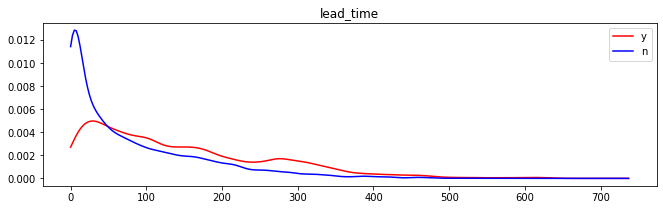

<Figure size 432x288 with 0 Axes>

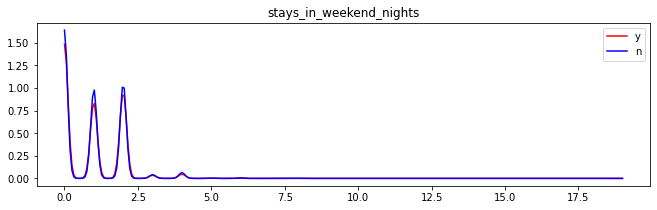

<Figure size 432x288 with 0 Axes>

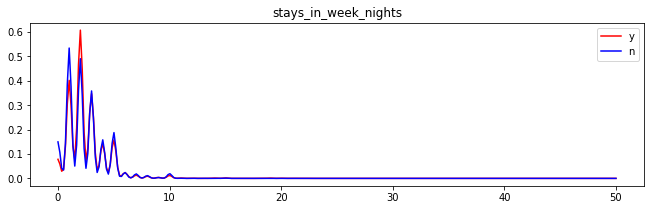

<Figure size 432x288 with 0 Axes>

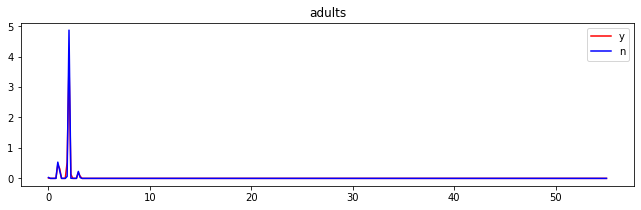

<Figure size 432x288 with 0 Axes>

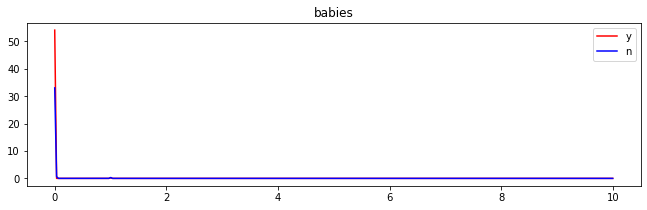

<Figure size 432x288 with 0 Axes>

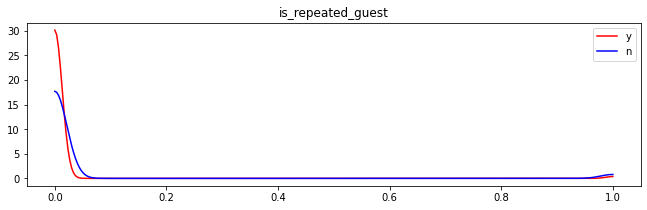

<Figure size 432x288 with 0 Axes>

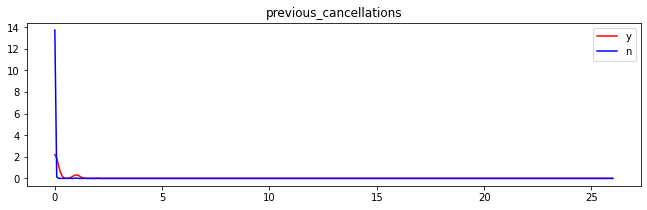

<Figure size 432x288 with 0 Axes>

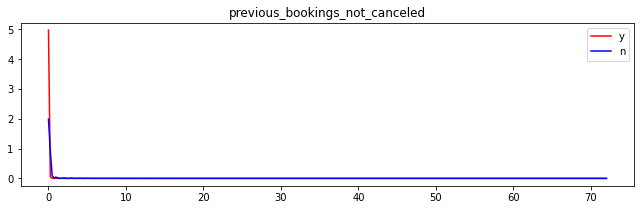

<Figure size 432x288 with 0 Axes>

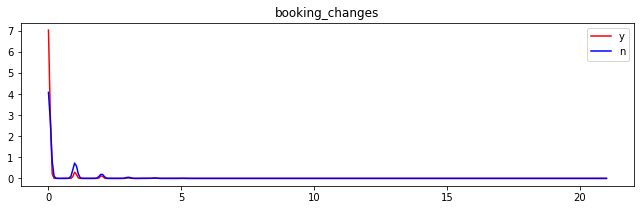

<Figure size 432x288 with 0 Axes>

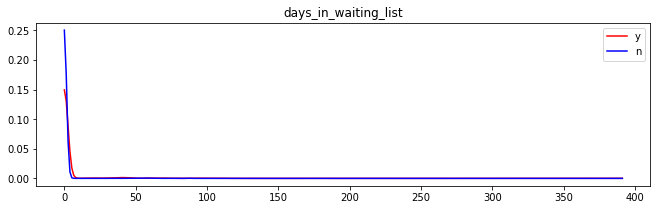

<Figure size 432x288 with 0 Axes>

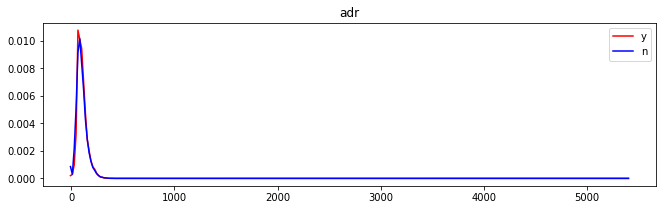

<Figure size 432x288 with 0 Axes>

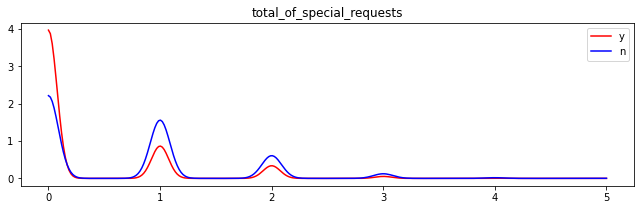

In [4]:
from scipy.stats import kde

i = 1
for col in hotels_df.columns:
    if hotels_df[col].dtype != 'object':
        try:
            density_y = kde.gaussian_kde(hotels_df[col].loc[hotels_df['is_canceled'] == 1])
        except:
            continue
        density_n = kde.gaussian_kde(hotels_df[col].loc[hotels_df['is_canceled'] == 0])
        x = np.linspace(np.min(hotels_df[col]),np.max(hotels_df[col]), 300)
        y_y = density_y(x)
        y_n = density_n(x)
        
        plt.figure(i)
        plt.figure(figsize = (11, 3)) 
        plt.plot(x, y_y, 'r-', label = 'y')
        plt.plot(x, y_n, 'b-', label = 'n')
        plt.title(col)
        plt.legend()
        plt.show()
        i = i + 1

In [5]:
abs(hotels_df.corr()['is_canceled']).sort_values(ascending = True)

stays_in_weekend_nights           0.001791
children                          0.005048
stays_in_week_nights              0.024765
babies                            0.032491
adr                               0.047557
days_in_waiting_list              0.054186
previous_bookings_not_canceled    0.057358
adults                            0.060017
agent                             0.083114
is_repeated_guest                 0.084793
previous_cancellations            0.110133
booking_changes                   0.144381
required_car_parking_spaces       0.195498
total_of_special_requests         0.234658
lead_time                         0.293123
is_canceled                       1.000000
Name: is_canceled, dtype: float64

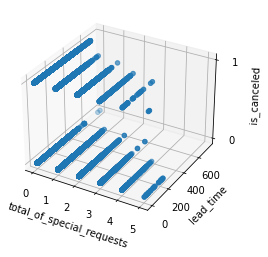

In [6]:
# plot the 2 variables of highest correlation to the variable to be predicted

fig = plt.figure()
plot = fig.add_subplot(projection='3d')

x = hotels_df['total_of_special_requests']
y = hotels_df['lead_time']
z = hotels_df['is_canceled']

plot.scatter(x, y, z)
plot.set_xlabel('total_of_special_requests')
plot.set_ylabel('lead_time')
plot.set_zticks([0, 1])
plot.set_zlabel('is_canceled')

plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

train_set, test_set = train_test_split(hotels_df, test_size = 0.4, random_state = 42)
X_train = train_set.drop(axis = 1, columns = ['is_canceled'])
y_train = train_set['is_canceled']
X_test = test_set.drop(axis = 1, columns = ['is_canceled'])
y_test = test_set['is_canceled']

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

categorical_transform1 = Pipeline([
    ("impute", SimpleImputer(strategy = "constant", fill_value = " ")),
    ("OH_encode", OneHotEncoder(handle_unknown = "ignore", sparse = False))
])

categorical_transform2 = Pipeline([
    ("impute", SimpleImputer(strategy = "constant", fill_value = " ")),
    ("O_encode", OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1))
])

full_pipeline = ColumnTransformer([
    ("numerical", SimpleImputer(strategy = "median"), [col for col in X_train.columns if X_train[col].dtype != 'object']),
    ("categorical_type1", 
     categorical_transform1, 
     [col for col in X_train.columns if (X_train[col].dtype == 'object' and X_train[col].nunique() <= 15)]),
    ("categorical_type2", 
     categorical_transform2, 
     [col for col in X_train.columns if (X_train[col].dtype == 'object' and X_train[col].nunique() > 15)])
])

full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("model", RandomForestClassifier())
])
            

In [9]:
# Encountered Issue with grid search -- taking far too long to process


# from sklearn.model_selection import GridSearchCV

# param_grid = [ {'model__n_estimators': [100, 200, 350, 500] ,
#                 'model__n_jobs': [-1], 
#                 'model__random_state':[42],
#                 'model__max_depth': [4, 10, 25]} ]

# grid_search = GridSearchCV(full_pipeline_with_predictor, 
#                            param_grid, cv = 3, n_jobs = -1, scoring = 'roc_auc', 
#                            return_train_score = True)

In [10]:
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [11]:
final_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("model", RandomForestClassifier(n_estimators = 150, n_jobs = -1, random_state = 42))
])

final_pipeline_with_predictor.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes', 'agent',
                                                   'days_in_waiting_list',
                                                   'adr',
                        

In [12]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

y_testpred = final_pipeline_with_predictor.predict(X_test)

print(precision_score(y_test, y_testpred))
print(recall_score(y_test, y_testpred))
print(roc_auc_score(y_test, y_testpred))

0.8820544554455445
0.8022738785388642
0.8693586205525693


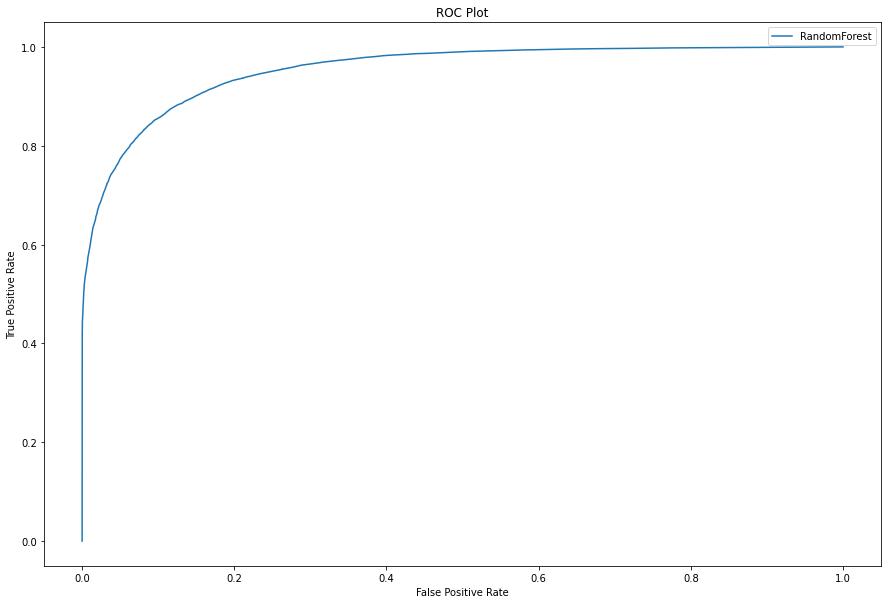

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np

y_testprob = final_pipeline_with_predictor.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_testprob)
plt.figure(figsize=(15, 10))   
plt.plot(fpr, tpr, label = 'RandomForest')
                   
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

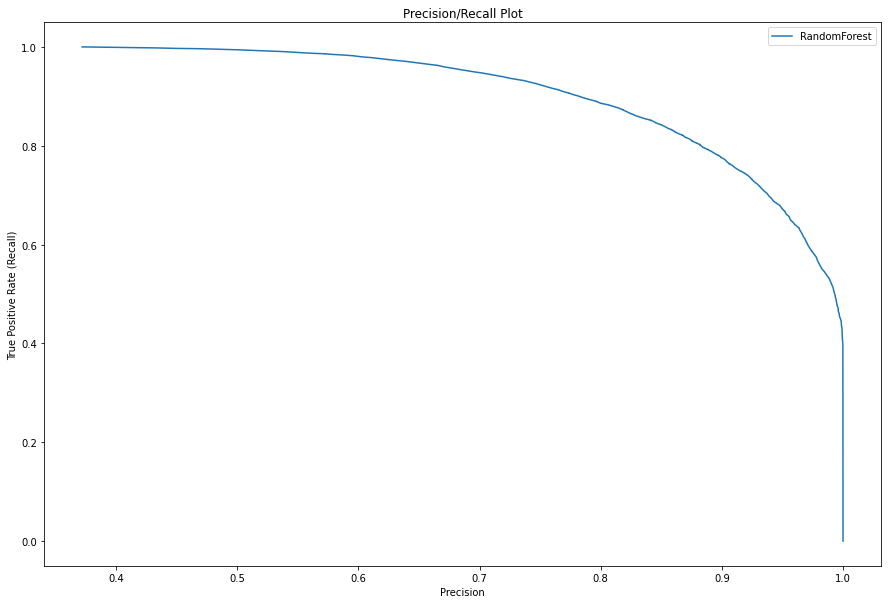

In [14]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_testprob)
plt.figure(figsize=(15, 10))   
plt.plot(precisions, recalls, label = 'RandomForest')

                             
plt.title('Precision/Recall Plot')
plt.xlabel('Precision')
plt.ylabel('True Positive Rate (Recall)')
plt.legend() 
plt.show()

In [26]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

categorical_transform1 = Pipeline([
    ("impute", SimpleImputer(strategy = "constant", fill_value = " ")),
    ("OH_encode", OneHotEncoder(handle_unknown = "ignore", sparse = False))
])

categorical_transform2 = Pipeline([
    ("impute", SimpleImputer(strategy = "constant", fill_value = " ")),
    ("O_encode", OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1))
])

full_pipeline = ColumnTransformer([
    ("numerical", SimpleImputer(strategy = "median"), [col for col in X_train.columns if X_train[col].dtype != 'object']),
    ("categorical_type1", 
     categorical_transform1, 
     [col for col in X_train.columns if (X_train[col].dtype == 'object' and X_train[col].nunique() <= 15)]),
    ("categorical_type2", 
     categorical_transform2, 
     [col for col in X_train.columns if (X_train[col].dtype == 'object' and X_train[col].nunique() > 15)])
])

class ClusterAugmentation(BaseEstimator, TransformerMixin):
    def __init__(self, n_components = 4):
        self.n_components = n_components
        self.labels = []
        self.reduced = []
        self.gm = GaussianMixture(n_components = self.n_components, n_init = 5)
        self.pca = PCA(n_components = 0.85)
    def fit(self, X, y = None):
        self.gm.fit(self.pca.fit_transform(X))
        return self 
    def transform(self, X):
        self.reduced = self.pca.transform(X)
        self.labels = self.gm.predict(self.reduced)
        clusters = np.reshape(self.labels, (len(self.labels), 1))
        return np.append(X, clusters, axis = 1)

full_pipeline_with_predictor2 = Pipeline([
        ("preparation", full_pipeline),
        ("clustering", ClusterAugmentation()),
        ("model", RandomForestClassifier(n_estimators = 150, n_jobs = -1, random_state = 42))
])
    

In [27]:
full_pipeline_with_predictor2.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes', 'agent',
                                                   'days_in_waiting_list',
                                                   'adr',
                        

In [28]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, silhouette_score

y_testpred = full_pipeline_with_predictor2.predict(X_test)

print(precision_score(y_test, y_testpred))
print(recall_score(y_test, y_testpred))
print(roc_auc_score(y_test, y_testpred))
print(silhouette_score(full_pipeline_with_predictor2.steps[1][1].reduced, full_pipeline_with_predictor2.steps[1][1].labels))

0.8833674545567343
0.8014296167051275
0.8693699819162038
0.32533465480572094
